In [1]:
import pandas as pd
import datetime
import numpy as np

# local file paths
input_path = f'../../../siads591 data/debris_yearly_gabbard_pkl/'
out_path = f'../../../siads591 data/gabbard/'

# start_year = first year file to look at
# end_year = last year file to look at (inclusive)
# freq = frequency of datapoints after reindexing
# interpolate_lim = limits of interpolation based on the frequency
#                   (1D frequency, 30 limit = 30 days 1 way, effectively a max of 60 days between points)
# out_file_name = output file name

# start_year, end_year, freq, interpolate_lim, out_file_name = 1960, 2021, '1D', 30, 'all_debris_1D.pkl'
start_year, end_year, freq, interpolate_lim, out_file_name = 1960, 2021, '12H', 90, 'all_debris_12H.pkl'

In [2]:
dfs = []
for y in range(start_year,end_year+1):
    df = pd.read_pickle(f'{input_path}{y}.pkl.gz', compression="gzip")
    dfs.append(df)
raw_df = pd.concat(dfs)

In [3]:
display(raw_df)
display(raw_df.dtypes)
display(raw_df.info())

,NORAD_CAT_ID,PERIOD,APOAPSIS,PERIAPSIS
EPOCH,,,,
1960-08-16 11:33:28.410048,51,118.248001,1690.036987,1514.431030
1960-08-16 11:41:13.296480,53,118.405998,1697.227051,1521.487061
1960-08-24 16:39:55.734048,51,118.286003,1690.285034,1517.640015
1960-08-24 16:52:59.167775,53,118.390999,1695.915039,1521.487061
1960-09-18 07:20:01.794048,51,118.246002,1689.970947,1514.365967
...,...,...,...,...
2021-01-18 21:54:04.595616,29110,97.584999,644.786011,641.546997
2021-01-18 22:33:11.999808,40274,96.713997,1046.178955,156.429001
2021-01-18 22:41:27.647232,39357,98.055000,671.218018,660.156006


NORAD_CAT_ID     uint32
PERIOD          float32
APOAPSIS        float32
PERIAPSIS       float32
dtype: object

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 76588309 entries, 1960-08-16 11:33:28.410048 to 2021-01-19 00:11:17.669760
Data columns (total 4 columns):
 #   Column        Dtype  
---  ------        -----  
 0   NORAD_CAT_ID  uint32 
 1   PERIOD        float32
 2   APOAPSIS      float32
 3   PERIAPSIS     float32
dtypes: float32(3), uint32(1)
memory usage: 1.7 GB


None

In [4]:
# create a new dataframe with min/max epoch of each satellite
reindexed_df = raw_df.reset_index().groupby(by="NORAD_CAT_ID").agg({'EPOCH':['min','max']})

# rename columns and add a np.nan column
reindexed_df.columns = ["_".join(x) for x in reindexed_df.columns.ravel()]
reindexed_df['key'] = np.nan

# generate valid EPOCH entries for each satellite
reindexed_df = reindexed_df.reset_index().merge(pd.DataFrame({'EPOCH':pd.date_range(start=raw_df.index.floor(freq=freq).min(), end=raw_df.index.max(), freq=freq),'key':np.nan}),on='key').drop('key',1)
reindexed_df = reindexed_df[(reindexed_df.EPOCH_min < reindexed_df.EPOCH) & (reindexed_df.EPOCH_max > reindexed_df.EPOCH)][['NORAD_CAT_ID','EPOCH']]

# save this value for later use
num_rows = len(reindexed_df)

# combine the generated table with the raw data
reindexed_df = reindexed_df.append(raw_df.reset_index(), ignore_index=True).sort_values(by=['NORAD_CAT_ID','EPOCH'])

# interpolate values for the generate EPOCH
reindexed_df = reindexed_df.interpolate(method='linear', limit_area="inside", limit=interpolate_lim, limit_direction='both')

# remove the raw data
reindexed_df = reindexed_df[reindexed_df.index < num_rows]

# set index
reindexed_df = reindexed_df.set_index('EPOCH')

In [5]:
display(reindexed_df)
display(reindexed_df.dtypes)
display(reindexed_df.info())

,NORAD_CAT_ID,PERIOD,APOAPSIS,PERIAPSIS
EPOCH,,,,
1960-08-16 12:00:00,51,118.250114,1690.050781,1514.609253
1960-08-17 00:00:00,51,118.252220,1690.064575,1514.787598
1960-08-17 12:00:00,51,118.254333,1690.078369,1514.965820
1960-08-18 00:00:00,51,118.256447,1690.092163,1515.144165
1960-08-18 12:00:00,51,118.258560,1690.105835,1515.322388
...,...,...,...,...
2021-01-17 00:00:00,47308,90.419502,390.523010,199.667999
2021-01-17 12:00:00,47308,90.390999,387.849670,199.550003
2021-01-18 00:00:00,47308,90.377998,386.702332,199.403992


NORAD_CAT_ID     uint64
PERIOD          float32
APOAPSIS        float32
PERIAPSIS       float32
dtype: object

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175928314 entries, 1960-08-16 12:00:00 to 2021-01-19 00:00:00
Data columns (total 4 columns):
 #   Column        Dtype  
---  ------        -----  
 0   NORAD_CAT_ID  uint64 
 1   PERIOD        float32
 2   APOAPSIS      float32
 3   PERIAPSIS     float32
dtypes: float32(3), uint64(1)
memory usage: 4.6 GB


None

In [6]:
reindexed_df.to_pickle(f"{out_path}{out_file_name}")

In [8]:
idx_vals = reindexed_df.index.value_counts()

<AxesSubplot:>

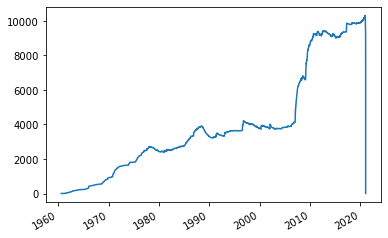

In [9]:
idx_vals.plot()